In [2]:
import numpy as np
from scipy.spatial.distance import squareform, pdist
from scipy.stats            import entropy
import pandas as pd

from multiprocessing import Pool
import os, glob
import re

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne   import _joint_probabilities

import seaborn as sns
import matplotlib.pyplot as plt

dat_dir = "/data/clintko/SMPK"
head = lambda x,n=6: x[:n]
tail = lambda x,n=6: x[-n:]

In [3]:
%matplotlib inline
%load_ext cython

In [9]:
def kldiv(P1, P2):
    """calculate KL divergence"""
    P1 = np.array(P1)
    P2 = np.array(P2)
    return entropy(P1.ravel(), P2.ravel())

def jsdiv(P1, P2):
    """calculate Jensen-Shannon Divergence"""
    return 0.5 * (kldiv(P1, P2) + kldiv(P2, P1))

def pairwise_jsdiv(mat_p1, mat_p2):
    """
    Arg:
        mat_p1, mat_p2: similarity matrix
    """
    mat_out = np.zeros((mat_p1.shape[1], mat_p2.shape[1]))
    for i in range(18):
        for j in range(18):
            p1 = mat_p1[:, i]
            p2 = mat_p2[:, j]
            mat_out[i, j] = jsdiv(p1, p2)
    return mat_out

In [25]:
%%cython -a

cimport cython
import numpy as np
from libc.math cimport log
from cython.parallel cimport prange, parallel

@cython.boundscheck(False)
cdef double entropy_ufun(double p, double q, double tol = 1e-50) nogil:
    if p < tol:
        return 0
    elif q < tol:
        return 0
    else:
        return p * log(p / q)
    
@cython.boundscheck(False)
cpdef double entropy_cy(double[:] p, double[:] q) nogil:
    cdef double epy = 0
    cdef int idx
    
    for idx in range(len(p)):
        epy += entropy_ufun(p[idx], q[idx])
    return epy

@cython.boundscheck(False)
cpdef double jsdiv_cy(double[:] p, double[:] q) nogil:
    return 0.5 * (entropy_cy(p, q) + entropy_cy(q, p))

@cython.boundscheck(False)
def pairwise_jsdiv_cy(double[:,:] mat_out, double[:,:] mat_p1, double[:,:] mat_p2):
    """
    Arg:
        mat_p1, mat_p2: similarity matrix
    """
    #mat_out = np.zeros((mat_p1.shape[1], mat_p2.shape[1]))
    cdef int i, j, m, n
    cdef double[:] p1, p2
    m = mat_p1.shape[1]
    n = mat_p2.shape[1]
    
    for i in range(m):
        for j in range(n):
            p1 = mat_p1[:, i]
            p2 = mat_p2[:, j]
            mat_out[i, j] = jsdiv_cy(p1, p2)

# Import data

In [6]:
p_raw = np.load(os.path.join(
    dat_dir, 
    "ep8cs_tsne_similarity" + "_raw.npy"))

# Test function

In [7]:
%%time
mat_raw2 = np.zeros((p_raw.shape[1], p_raw.shape[1]))
pairwise_jsdiv_cy(mat_raw2, p_raw, p_raw)

CPU times: user 4min 16s, sys: 1.23 s, total: 4min 17s
Wall time: 4min 16s


In [10]:
%%time
mat_raw1 = pairwise_jsdiv(p_raw, p_raw)

CPU times: user 12min 32s, sys: 5min 32s, total: 18min 4s
Wall time: 18min 5s


In [15]:
mat_raw1[:2, :2]

array([[ 0.        , 22.92807282],
       [22.92807282,  0.        ]])

In [14]:
mat_raw2[:2, :2]

array([[ 0.        , 11.46403666],
       [11.46403666,  0.        ]])

In [20]:
jsdiv(p_raw[:,0], p_raw[:,1])

22.928072821978397

In [21]:
jsdiv_cy(p_raw[:,0], p_raw[:,1])

11.464036655756246

In [22]:
entropy(p_raw[:,0], p_raw[:,1])

22.94258360968641

In [26]:
entropy_cy(p_raw[:,0], p_raw[:,1])

11.471292049363324

In [29]:
p1 = p_raw[:,0]
p2 = p_raw[:,1]
np.sum(p1 * np.log(p1 / p2))

11.471292049362575

In [31]:
mat = np.r_[p_raw, p_raw]
p1 = mat[:,0]
p2 = mat[:,1]
np.sum(p1 * np.log(p1 / p2))

22.942584098725167

In [12]:
np.allclose(mat_raw1, mat_raw2)

False

```
"ep8cs_tsne_similarity_cal_prior50.npy"
"ep8cs_tsne_jsdiv_raw.npy"
"ep8cs_tsne_jsdiv_raw_cal_prior50.npy"
```

# Raw data

In [55]:
p_raw = np.load(os.path.join(
    dat_dir, 
    "ep8cs_tsne_similarity" + "_raw.npy"))

In [57]:
mat_jsdiv_raw = fun2(p_raw)

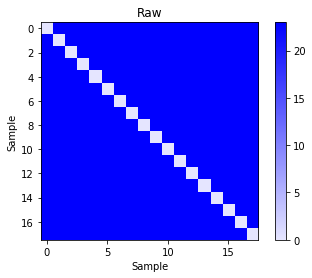

In [58]:
pal = sns.light_palette("blue", as_cmap=True)
plt.imshow(mat_jsdiv_rawsdiv_raw, interpolation='none', cmap=pal)
plt.title("Raw")
plt.xlabel("Sample")
plt.ylabel("Sample")
plt.colorbar()

In [62]:
np.diag(mat_jsdiv_raw)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [59]:
dat_dir + "ep8cs_tsne_jsdiv_raw.npy"

'/data/clintko/SMPKep8cs_tsne_jsdiv_raw.npy'

In [60]:
os.path.join(dat_dir, "ep8cs_tsne_jsdiv_raw.npy")

'/data/clintko/SMPK/ep8cs_tsne_jsdiv_raw.npy'

In [ ]:
np.save(os.path.join(dat_dir, "ep8cs_tsne_jsdiv_raw.npy"), mat_jsdiv_raw)

# calibrated data

In [61]:
pattern = "prior([0-9]*)"
priors = [
    re.findall(pattern, x)[0] 
    for x in os.listdir(dat_dir) 
    if "ep8cs_tsne_similarity_cal" in x]
print(priors)

['05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '20', '25', '30', '35', '40', '45', '50']


In [ ]:
def read_similarity_matrix(prior):
    mat = np.load(
        os.path.join(
            dat_dir, 
            "ep8cs_tsne_similarity_cal_prior" + prior + ".npy"
        ) # end os.path.join
    ) # end np.load
    return mat

pool  = Pool()
%time p_cal = pool.map(read_similarity_matrix, priors)

In [19]:
os.cpu_count()

24

In [136]:
p_raw.shape

(49995000, 18)

In [ ]:
def fun1(mat_p):
    return pairwise_jsdiv(mat_p, mat_p)

def fun2(mat_p):
    return pairwise_jsdiv(p_raw, mat_p)

%time mat_jsdiv_cal        = pool.map(fun1, p_cal)
%time mat_jsdiv_raw_vs_cal = pool.map(fun2, p_cal)